In [1]:
import gym
import torch
from gym import spaces
from collections import defaultdict
import heapq
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../Env/2D/')
from DMP_Env_2D_static import deep_mobile_printing_2d1r
import heapq 

In [2]:
# env = deep_mobile_printing_2d1r(plan_choose=1)
# obs = env.reset()
# initial_position=[0,0]
# # initial_action_prior=np.random.choice(4,1,p=[0, .5, 0, .5])

# # 0 left, 1 right, 2 up, 3 down , 4drop

# initial_action_prior=[0, 0, 0, 0] # means we initially assume go down and right is advanced action 

In [3]:
def localization(action, obs, new_obs, previous_position):
    [x,y]=previous_position
    # 0 left, 1 right, 2 up, 3 down, 4 drop
    obs = obs[0][:49].reshape(7, 7)
    new_obs = new_obs[0][:49].reshape(7, 7)
    size_x = len(obs)
    size_y = len(obs[0])

    new_x, new_y = x, y
    dx = [-1, 1, 0, 0]
    dy = [0, 0, 1, -1]
    if action == 4:
        return new_x, new_y
    elif (obs == new_obs).all():
        print('enter action_none')
        new_x = x + dx[action]
        new_y = y + dy[action]


    else:
        if action == 0:
            if (obs[:, :size_x + dx[action]] == new_obs[:, -dx[action]:]).all():
                print('enter action0_1')
                new_x = x + dx[action]
            elif (obs[:, :size_x + 2 * dx[action]] == new_obs[:, -2 * dx[action]:]).all():
                print('enter action0_2')
                new_x = x + 2 * dx[action]
            elif (obs[:, :size_x + 3 * dx[action]] == new_obs[:, -3 * dx[action]:]).all():
                print('enter action0_3')
                new_x = x + 3 * dx[action]
        elif action == 1:  # right
            if (new_obs[:, :size_x - dx[action]] == obs[:, dx[action]:]).all():
                print('enter action1_1')
                new_x = x + dx[action]
            elif (new_obs[:, :size_x - 2 * dx[action]] == obs[:, 2 * dx[action]:]).all():
                print('enter action1_2')
                new_x = x + 2 * dx[action]
            elif (new_obs[:, :size_x - 3 * dx[action]] == obs[:, 3 * dx[action]:]).all():
                print('enter action1_3')
                new_x = x + 3 * dx[action]
        elif action == 2:  # up
            if (new_obs[:size_y - dy[action], :] == obs[dy[action]:, :]).all():
                print('enter action2_1')
                new_y = y + dy[action]
            elif (new_obs[:size_y - 2 * dy[action], :] == obs[2 * dy[action]:, :]).all():
                print('enter action2_2')
                new_y = y + 2 * dy[action]
            elif (new_obs[:size_y - 3 * dy[action], :] == obs[3 * dy[action]:, :]).all():
                print('enter action2_3')
                new_y = y + 3 * dy[action]
        elif action == 3:
            if (obs[:size_y + dy[action], :] == new_obs[-dy[action]:, :]).all():
                print('enter action3_1')
                new_y = y + dy[action]
            elif (obs[:size_y + 2 * dy[action], :] == new_obs[-2 * dy[action]:, :]).all():
                print('enter action3_2')
                new_y = y + 2 * dy[action]
            elif (obs[:size_y + 3 * dy[action], :] == new_obs[-3 * dy[action]:, :]).all():
                print('enter action3_3')
                new_y = y + 3 * dy[action]

    if new_x < 0: new_x = 0
    if new_x >= env.plan_width: new_x = env.plan_width - 1
    if new_y < 0: new_y = 0
    if new_y > env.plan_width: new_y = env.plan_width - 1

    # if the robot can see the wall, it can localize its position
    dff_y = 0
    dff_x = 0
    mid = size_x // 2

    if new_obs[0][mid] == -1.0:  # check upper_all
        print('check_up')
        for i in range(1, env.HALF_WINDOW_SIZE):
            if new_obs[i][mid] == -1.0:
                dff_y -= 1
        new_y = env.HALF_WINDOW_SIZE - 1 + dff_y
    elif new_obs[size_y - 1][mid] == -1.0:  # check down_wall
        print('check_down')
        for i in range(size_y - 2, env.HALF_WINDOW_SIZE, -1):
            if new_obs[i][mid] == -1.0:
                dff_y += 1
        new_y = env.plan_height - env.HALF_WINDOW_SIZE + dff_y
    if new_obs[mid][0] == -1.0:  # check left_wall
        print('check_left')
        for i in range(1, env.HALF_WINDOW_SIZE):
            if new_obs[mid][i] == -1.0:
                dff_x -= 1
        new_x = env.HALF_WINDOW_SIZE - 1 + dff_x
    elif new_obs[mid][size_x - 1] == -1.0:  # check right_wall
        print('check_right')
        for i in range(size_x - 2, env.HALF_WINDOW_SIZE, -1):
            if new_obs[mid][i] == -1.0:
                dff_x += 1
        new_x = env.plan_width - env.HALF_WINDOW_SIZE + dff_x
    return [new_x, new_y]

In [4]:
def planing(position,obs,current_action_prior):
    ###   reshape the input value 
    obs = obs[0][:49].reshape(7, 7)
    current_position_row = position[0] + env.HALF_WINDOW_SIZE
    current_position_column = position[1] + env.HALF_WINDOW_SIZE
    
    ######### determine the current action prior 
    
    if (obs[:,0] == -1).all() or (obs[:,0:1] == -1).all()  or (obs[:,0:2] == -1).all(): ## in this case, robot observe left wall, so move right will be advanced
        current_action_prior[0]=0
        current_action_prior[1]=0.5
    if (obs[0,:] == -1).all() or (obs[0:1,:] == -1).all()  or (obs[0:2,:] == -1).all(): ## in this case, robot observe bottom wall, so move down will be advanced
        current_action_prior[2]=0.5
        current_action_prior[3]=0
    if (obs[:,6] == -1).all() or (obs[:,5:6] == -1).all()  or (obs[:,4:6] == -1).all(): ## in this case, robot observe right wall, so move left will be advanced
        current_action_prior[0]=0.5
        current_action_prior[1]=0
    if (obs[6,:] == -1).all() or (obs[5:6,:] == -1).all()  or (obs[4:6,:] == -1).all(): ## in this case, robot observe top wall, so move up will be advanced
        current_action_prior[2]=0
        current_action_prior[3]=0.5
        
    ##### check the observation with the design D 
    distance_array=[]
    for i in range(7):
        for j in range(7):
            if obs[i,j]==-1:
                heapq.heappush(distance_array, (np.inf, [i,j]))
            else:
                if obs[i,j]==0 and env.plan[current_position_row-(3-i),current_position_column-(3-j)]==0:
                    heapq.heappush(distance_array, (np.inf, [i,j]))
                if obs[i,j]==1 and env.plan[current_position_row-(3-i),current_position_column-(3-j)]==0:
                    heapq.heappush(distance_array, (np.inf, [i,j]))
                if obs[i,j]==1 and env.plan[current_position_row-(3-i),current_position_column-(3-j)]==1:
                    heapq.heappush(distance_array, (np.inf, [i,j]))
                if obs[i,j]==0 and env.plan[current_position_row-(3-i),current_position_column-(3-j)]==1:
                    heapq.heappush(distance_array, (np.abs(3-i)+np.abs(3-j), [i,j]))
    print(distance_array)
    smallest_distance_candidate=[]
    smallest_distance_candidate.append(heapq.heappop(distance_array))
    if smallest_distance_candidate[0][0]==np.inf:  ### in this case, all the position should not be built and also dont know where to move 
        action = np.random.choice(4, p=current_action_prior) ### so we choose action base on priority 
        return action, current_action_prior  
    else:           ### in this case, we store all all the possible position for next step
        for i in range(49):
            smallest_distance_candidate.append(heapq.heappop(distance_array))
            if smallest_distance_candidate[0][0] != smallest_distance_candidate[-1][0]:
                break
        smallest_distance_candidate.remove(smallest_distance_candidate[-1])
        print(smallest_distance_candidate)
    ### in this case we need to decide action base on candidate position 
    if smallest_distance_candidate[0][0]==0:
        action=4 #### in this case, the robot should build brick on its current position 
        return action,current_action_prior 
    else: 
        index=np.random.choice(len(smallest_distance_candidate))
        decided_position=smallest_distance_candidate[index][1]
        
        ##############
    if decided_position[0]>3 and decided_position[1]>3:
        action = np.random.choice([1,2])
        return action,current_action_prior 
    if decided_position[0]>3 and decided_position[1]<3:
        action = np.random.choice([0,2])
        return action,current_action_prior 
    if decided_position[0]<3 and decided_position[1]<3:
        action = np.random.choice([0,3])
        return action,current_action_prior 
    if decided_position[0]<3 and decided_position[1]>3:
        action = np.random.choice([1,3])
        return action,current_action_prior 
    ################ 
    if decided_position[0]==3:
        if decided_position[1]>3:
            action = 1 
            return action,current_action_prior
        else:
            action = 0 
            return action,current_action_prior    
    if decided_position[1]==3:
        if decided_position[0]>3:
            action = 2
            return action,current_action_prior 
        else:
            action = 3 
            return action,current_action_prior  

60.0
start
[(inf, [0, 0]), (inf, [0, 1]), (inf, [0, 2]), (inf, [0, 3]), (inf, [0, 4]), (inf, [0, 5]), (inf, [0, 6]), (inf, [1, 0]), (inf, [1, 1]), (inf, [1, 2]), (inf, [1, 3]), (inf, [1, 4]), (inf, [1, 5]), (inf, [1, 6]), (inf, [2, 0]), (inf, [2, 1]), (inf, [2, 2]), (inf, [2, 3]), (inf, [2, 4]), (inf, [2, 5]), (inf, [2, 6]), (inf, [3, 0]), (inf, [3, 1]), (inf, [3, 2]), (inf, [3, 3]), (inf, [3, 4]), (inf, [3, 5]), (inf, [3, 6]), (inf, [4, 0]), (inf, [4, 1]), (inf, [4, 2]), (inf, [4, 3]), (inf, [4, 4]), (inf, [4, 5]), (inf, [4, 6]), (inf, [5, 0]), (inf, [5, 1]), (inf, [5, 2]), (inf, [5, 3]), (inf, [5, 4]), (inf, [5, 5]), (inf, [5, 6]), (inf, [6, 0]), (inf, [6, 1]), (inf, [6, 2]), (inf, [6, 3]), (inf, [6, 4]), (inf, [6, 5]), (inf, [6, 6])]
action 1
enter action1_1
check_up
check_left
position 0 1
location 0 1
#################


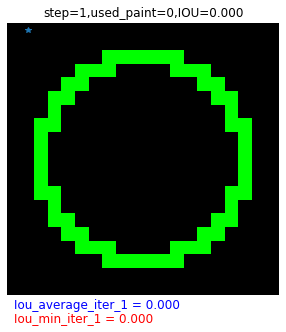

[(inf, [0, 0]), (inf, [0, 1]), (inf, [0, 2]), (inf, [0, 3]), (inf, [0, 4]), (inf, [0, 5]), (inf, [0, 6]), (inf, [1, 0]), (inf, [1, 1]), (inf, [1, 2]), (inf, [1, 3]), (inf, [1, 4]), (inf, [1, 5]), (inf, [1, 6]), (inf, [2, 0]), (inf, [2, 1]), (inf, [2, 2]), (inf, [2, 3]), (inf, [2, 4]), (inf, [2, 5]), (inf, [2, 6]), (inf, [3, 0]), (inf, [3, 1]), (inf, [3, 2]), (inf, [3, 3]), (inf, [3, 4]), (inf, [3, 5]), (inf, [3, 6]), (inf, [4, 0]), (inf, [4, 1]), (inf, [4, 2]), (inf, [4, 3]), (inf, [4, 4]), (inf, [4, 5]), (inf, [4, 6]), (inf, [5, 0]), (inf, [5, 1]), (inf, [5, 2]), (inf, [5, 3]), (inf, [5, 4]), (inf, [5, 5]), (inf, [5, 6]), (inf, [6, 0]), (inf, [6, 1]), (inf, [6, 2]), (inf, [6, 3]), (inf, [6, 4]), (inf, [6, 5]), (inf, [6, 6])]
action 1
enter action1_2
check_up
position 0 4
location 0 3
#################


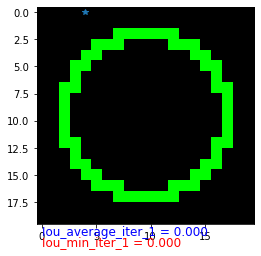

[(5, [6, 5]), (inf, [0, 1]), (6, [6, 6]), (inf, [0, 3]), (inf, [0, 4]), (inf, [0, 0]), (inf, [0, 6]), (inf, [1, 0]), (inf, [1, 1]), (inf, [1, 2]), (inf, [1, 3]), (inf, [0, 2]), (inf, [1, 5]), (inf, [1, 6]), (inf, [2, 0]), (inf, [2, 1]), (inf, [2, 2]), (inf, [2, 3]), (inf, [2, 4]), (inf, [2, 5]), (inf, [2, 6]), (inf, [3, 0]), (inf, [3, 1]), (inf, [0, 5]), (inf, [3, 3]), (inf, [3, 4]), (inf, [3, 5]), (inf, [3, 6]), (inf, [4, 0]), (inf, [4, 1]), (inf, [4, 2]), (inf, [4, 3]), (inf, [4, 4]), (inf, [4, 5]), (inf, [4, 6]), (inf, [5, 0]), (inf, [5, 1]), (inf, [5, 2]), (inf, [5, 3]), (inf, [5, 4]), (inf, [5, 5]), (inf, [5, 6]), (inf, [6, 0]), (inf, [6, 1]), (inf, [6, 2]), (inf, [6, 3]), (inf, [6, 4]), (inf, [3, 2]), (inf, [1, 4])]
[(5, [6, 5])]
action 2
enter action2_1
check_up
position 1 4
location 1 3
#################


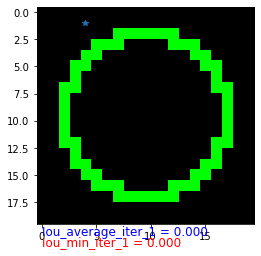

[(4, [5, 5]), (4, [6, 4]), (5, [6, 5]), (inf, [0, 3]), (5, [5, 6]), (inf, [0, 2]), (inf, [0, 6]), (inf, [1, 0]), (inf, [1, 1]), (inf, [0, 1]), (inf, [0, 0]), (inf, [0, 5]), (inf, [1, 5]), (inf, [1, 6]), (inf, [2, 0]), (inf, [2, 1]), (inf, [2, 2]), (inf, [2, 3]), (inf, [2, 4]), (inf, [1, 2]), (inf, [0, 4]), (inf, [3, 0]), (inf, [1, 3]), (inf, [1, 4]), (inf, [3, 3]), (inf, [3, 4]), (inf, [3, 5]), (inf, [3, 6]), (inf, [4, 0]), (inf, [4, 1]), (inf, [4, 2]), (inf, [4, 3]), (inf, [4, 4]), (inf, [4, 5]), (inf, [4, 6]), (inf, [5, 0]), (inf, [5, 1]), (inf, [5, 2]), (inf, [5, 3]), (inf, [5, 4]), (inf, [2, 5]), (inf, [2, 6]), (inf, [6, 0]), (inf, [6, 1]), (inf, [6, 2]), (inf, [6, 3]), (inf, [3, 1]), (inf, [3, 2]), (inf, [6, 6])]
[(4, [5, 5]), (4, [6, 4])]
action 1
enter action_none
check_up
position 1 5
location 1 4
#################


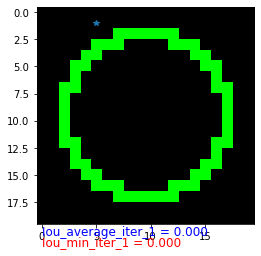

[(3, [5, 4]), (3, [6, 3]), (inf, [0, 2]), (inf, [0, 1]), (4, [4, 6]), (inf, [0, 5]), (inf, [0, 6]), (inf, [0, 3]), (inf, [1, 1]), (5, [5, 6]), (4, [5, 5]), (inf, [1, 4]), (inf, [1, 5]), (inf, [1, 6]), (inf, [2, 0]), (inf, [2, 1]), (inf, [1, 0]), (inf, [2, 3]), (inf, [2, 4]), (inf, [0, 4]), (inf, [0, 0]), (inf, [3, 0]), (4, [6, 4]), (inf, [3, 2]), (inf, [3, 3]), (inf, [3, 4]), (inf, [3, 5]), (inf, [3, 6]), (inf, [4, 0]), (inf, [4, 1]), (inf, [4, 2]), (inf, [4, 3]), (inf, [4, 4]), (inf, [4, 5]), (inf, [2, 2]), (inf, [5, 0]), (inf, [5, 1]), (inf, [5, 2]), (inf, [5, 3]), (inf, [2, 5]), (inf, [1, 2]), (inf, [2, 6]), (inf, [6, 0]), (inf, [6, 1]), (inf, [6, 2]), (inf, [3, 1]), (inf, [1, 3]), (inf, [6, 5]), (inf, [6, 6])]
[(3, [5, 4]), (3, [6, 3])]
action 2
enter action2_2
position 4 5
location 3 4
#################


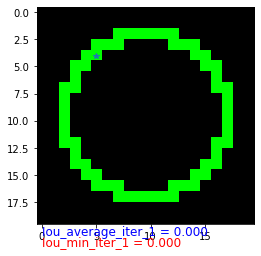

[(1, [3, 4]), (1, [4, 3]), (2, [3, 5]), (2, [4, 4]), (4, [6, 2]), (4, [2, 6]), (3, [3, 6]), (inf, [0, 0]), (2, [5, 3]), (inf, [0, 4]), (inf, [0, 1]), (inf, [1, 4]), (inf, [0, 2]), (inf, [0, 6]), (inf, [2, 0]), (inf, [0, 3]), (inf, [2, 2]), (inf, [2, 3]), (3, [5, 2]), (inf, [2, 5]), (inf, [1, 2]), (inf, [1, 3]), (inf, [3, 1]), (inf, [3, 2]), (inf, [3, 3]), (inf, [1, 5]), (inf, [0, 5]), (inf, [1, 6]), (inf, [4, 0]), (inf, [4, 1]), (inf, [4, 2]), (inf, [2, 1]), (inf, [1, 0]), (inf, [4, 5]), (inf, [4, 6]), (inf, [5, 0]), (inf, [5, 1]), (inf, [2, 4]), (inf, [1, 1]), (inf, [5, 4]), (inf, [5, 5]), (inf, [5, 6]), (inf, [6, 0]), (inf, [6, 1]), (inf, [3, 0]), (inf, [6, 3]), (inf, [6, 4]), (inf, [6, 5]), (inf, [6, 6])]
[(1, [3, 4]), (1, [4, 3])]
action 2
enter action_none
position 7 5
location 4 4
#################


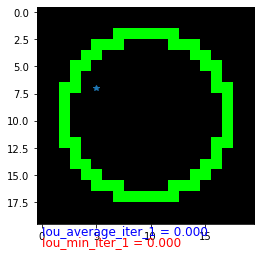

[(0, [3, 3]), (1, [4, 3]), (1, [3, 4]), (3, [2, 5]), (4, [2, 6]), (2, [2, 4]), (2, [4, 2]), (inf, [0, 1]), (3, [5, 2]), (5, [1, 6]), (4, [6, 2]), (inf, [0, 5]), (inf, [0, 0]), (inf, [0, 6]), (inf, [0, 2]), (inf, [1, 0]), (inf, [2, 2]), (inf, [2, 3]), (inf, [0, 3]), (inf, [1, 2]), (inf, [0, 4]), (5, [6, 1]), (inf, [3, 1]), (inf, [3, 2]), (inf, [1, 4]), (inf, [1, 5]), (inf, [3, 5]), (inf, [3, 6]), (inf, [4, 0]), (inf, [4, 1]), (inf, [2, 0]), (inf, [2, 1]), (inf, [4, 4]), (inf, [4, 5]), (inf, [4, 6]), (inf, [5, 0]), (inf, [5, 1]), (inf, [1, 1]), (inf, [5, 3]), (inf, [5, 4]), (inf, [5, 5]), (inf, [5, 6]), (inf, [6, 0]), (inf, [3, 0]), (inf, [1, 3]), (inf, [6, 3]), (inf, [6, 4]), (inf, [6, 5]), (inf, [6, 6])]
[(0, [3, 3])]
action 4
position 7 5
location 4 4
#################


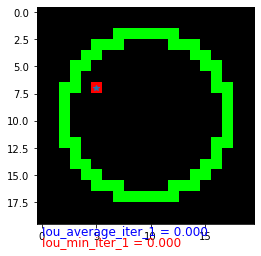

[(1, [3, 4]), (1, [4, 3]), (2, [2, 4]), (3, [2, 5]), (4, [2, 6]), (inf, [0, 0]), (2, [4, 2]), (inf, [0, 1]), (3, [5, 2]), (5, [1, 6]), (4, [6, 2]), (inf, [1, 4]), (inf, [0, 5]), (inf, [0, 6]), (inf, [0, 2]), (inf, [1, 0]), (inf, [2, 2]), (inf, [2, 3]), (inf, [0, 3]), (inf, [1, 2]), (inf, [0, 4]), (5, [6, 1]), (inf, [3, 1]), (inf, [3, 2]), (inf, [3, 3]), (inf, [1, 5]), (inf, [3, 5]), (inf, [3, 6]), (inf, [4, 0]), (inf, [4, 1]), (inf, [2, 0]), (inf, [2, 1]), (inf, [4, 4]), (inf, [4, 5]), (inf, [4, 6]), (inf, [5, 0]), (inf, [5, 1]), (inf, [1, 1]), (inf, [5, 3]), (inf, [5, 4]), (inf, [5, 5]), (inf, [5, 6]), (inf, [6, 0]), (inf, [3, 0]), (inf, [1, 3]), (inf, [6, 3]), (inf, [6, 4]), (inf, [6, 5]), (inf, [6, 6])]
[(1, [3, 4]), (1, [4, 3])]
action 1
enter action1_2
position 7 7
location 4 6
#################


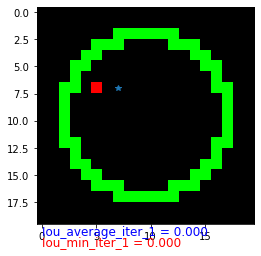

[(1, [2, 3]), (2, [2, 2]), (1, [3, 2]), (2, [2, 4]), (6, [6, 0]), (4, [1, 5]), (3, [4, 1]), (inf, [0, 3]), (3, [1, 4]), (inf, [0, 4]), (inf, [1, 3]), (inf, [0, 0]), (inf, [0, 2]), (5, [1, 6]), (4, [4, 0]), (inf, [2, 1]), (inf, [1, 0]), (5, [5, 0]), (inf, [0, 1]), (inf, [2, 5]), (inf, [1, 2]), (inf, [3, 0]), (inf, [3, 1]), (inf, [0, 5]), (inf, [3, 3]), (inf, [3, 4]), (inf, [3, 5]), (inf, [3, 6]), (inf, [0, 6]), (inf, [2, 0]), (inf, [4, 2]), (inf, [4, 3]), (inf, [4, 4]), (inf, [4, 5]), (inf, [4, 6]), (inf, [1, 1]), (inf, [5, 1]), (inf, [5, 2]), (inf, [5, 3]), (inf, [5, 4]), (inf, [5, 5]), (inf, [5, 6]), (inf, [2, 6]), (inf, [6, 1]), (inf, [6, 2]), (inf, [6, 3]), (inf, [6, 4]), (inf, [6, 5]), (inf, [6, 6])]
[(1, [2, 3]), (1, [3, 2])]
action 0
enter action0_2
position 7 5
location 4 4
#################


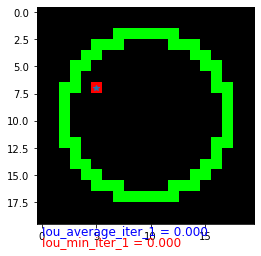

[(1, [3, 4]), (1, [4, 3]), (2, [2, 4]), (3, [2, 5]), (4, [2, 6]), (inf, [0, 0]), (2, [4, 2]), (inf, [0, 1]), (3, [5, 2]), (5, [1, 6]), (4, [6, 2]), (inf, [1, 4]), (inf, [0, 5]), (inf, [0, 6]), (inf, [0, 2]), (inf, [1, 0]), (inf, [2, 2]), (inf, [2, 3]), (inf, [0, 3]), (inf, [1, 2]), (inf, [0, 4]), (5, [6, 1]), (inf, [3, 1]), (inf, [3, 2]), (inf, [3, 3]), (inf, [1, 5]), (inf, [3, 5]), (inf, [3, 6]), (inf, [4, 0]), (inf, [4, 1]), (inf, [2, 0]), (inf, [2, 1]), (inf, [4, 4]), (inf, [4, 5]), (inf, [4, 6]), (inf, [5, 0]), (inf, [5, 1]), (inf, [1, 1]), (inf, [5, 3]), (inf, [5, 4]), (inf, [5, 5]), (inf, [5, 6]), (inf, [6, 0]), (inf, [3, 0]), (inf, [1, 3]), (inf, [6, 3]), (inf, [6, 4]), (inf, [6, 5]), (inf, [6, 6])]
[(1, [3, 4]), (1, [4, 3])]
action 1
enter action1_2
position 7 7
location 4 6
#################


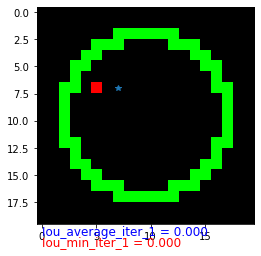

reward: 0


In [5]:
env = deep_mobile_printing_2d1r(plan_choose=1)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
total_reward = 0
obs = env.reset()
env.render(ax)
print(env.total_brick)
current_position=[0,0]
current_position_l=[0,0]
current_action_prior=[0, 0, 0, 0] 
# print('location', x, y)
# print('position', env.position_memory[-1][1] - 3, env.position_memory[-1][0] - 3)
print('start')
for i in range(700):
    action,next_action_prior = planing(current_position,obs,current_action_prior)
    print('action', action)
    new_obs, reward, done = env.step(action)
    next_position = localization(action, obs, new_obs, current_position_l)
    print('position', env.position_memory[-1][0] - 3, env.position_memory[-1][1] - 3)
    print('location', next_position[1], next_position[0])
    print('#################')

    env.render(ax)
    plt.pause(2)
    total_reward += reward
    obs = new_obs
    current_position=[next_position[1],next_position[0]]
    current_position_l=next_position
    current_action_prior=next_action_prior
    if done:
        break
print("reward:", total_reward)
plt.show()

In [1]:
import numpy as np

In [3]:
a=np.array([[-1., -1., 17.,  0.,  0.]])

In [4]:
b=np.array([[ 17.,  0.,  0.,0.,0.]])

In [7]:
np.array_equal(a[0,2:], b[0,:-2])

True